---
title: 12.6 目标检测数据集
date: 2024-8-13 13:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---

#### 

<!--more-->

# 6 目标检测数据集

## 6.1 下载数据集

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

## 6.2 读取数据集

- 读取香蕉检测数据集。该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。

In [2]:
#@save
def read_data_bananas(is_train = True):
    '''读取香蕉检测数据集中的图像和标签'''
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name') # 将图像文件名设置为索引
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', img_name)))
        # 将边界框存储为浮点数类型的张量
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(0)/256

- 创建一个自定义Dataset实例来加载香蕉检测数据集

In [3]:
#@save
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[:, idx])
    
    def __len__(self):
        return len(self.features)

- 为训练集和测试集返回两个数据加载器实例。对于测试集，无须按随机顺序读取它。

In [4]:
#@save
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train = True), batch_size, shuffle = True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train = False), batch_size, shuffle = False)
    return train_iter, val_iter

- 读取一个小批量，并打印其中的图像和标签的形状。

- 图像的小批量的形状为（批量大小、通道数、高度、宽度)

- 标签的小批量的形状为（批量大小，m，5），其中m是数据集的任何图像中边界框可能出现的最大数量。

- 小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。通常来说，图像可能拥有不同数量个边界框；因此，在达到m之前，边界框少于m的图像将被非法边界框填充。这样，每个边界框的标签将被长度为5的数组表示。数组中的第一个元素是边界框中对象的类别，其中‐1表示用于填充的非法边界框。数组的其余四个元素是边界框左上角和右下角的（x，y）坐标值（值域在0～1之间）。对于香蕉数据集而言，由于每张图像上只有一个边界框，因此m=1。

In [5]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## 6.3 演示

- 展示10幅带有真实边界框的图像。我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。

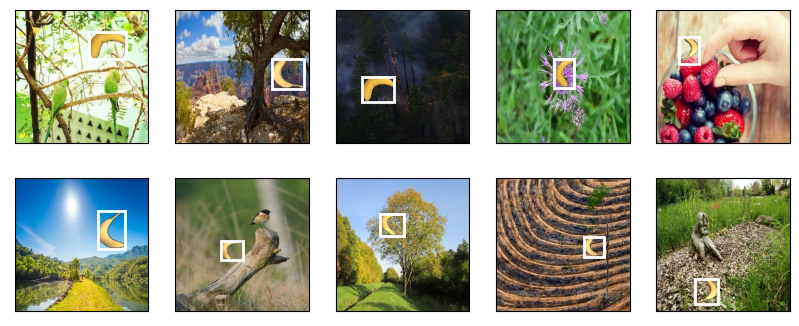

In [6]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])